# a first simplified 2D barotropic model
Use FFT in periodic 2D domain

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.fft import fft2, ifft2
from scipy.misc import derivative
import math as mt

%load_ext autoreload
%autoreload 1
%matplotlib inline
#%matplotlib notebook

def plot_model(psi, zeta, timestep):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(2,2,1)
    h1=ax.contourf(np.real(psi))
    ax.set_title(f'Stream function at time step {timestep}')
    fig.colorbar(h1)
    ax = fig.add_subplot(2,2,2)
    h2=ax.contourf(np.real(zeta))
    ax.set_title(f'Vorticity at time step {timestep}')
    fig.colorbar(h2)
    plt.show()
    return

N = 96
T = 2001
deltaT = 0.000001
Tplot = 500
beta = 0.1

x = np.linspace(-2*mt.pi, 2*mt.pi, N)
y = np.linspace(-2*mt.pi, 2*mt.pi, N)
x, y = np.meshgrid(x, y)

def multivariate_gaussian(pos, mu, sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    sigma_det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    N = np.sqrt((2*np.pi)**n * sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[-2.54393017e-03 -3.09685493e-03 -3.73494091e-03 ...  3.94550295e-08
   3.36311628e-08  2.84005519e-08]
 [-3.09685493e-03 -3.76117324e-03 -4.52556711e-03 ...  6.11569187e-08
   5.20080107e-08  4.38168286e-08]
 [-3.73494091e-03 -4.52556711e-03 -5.43262191e-03 ...  9.39148971e-08
   7.96791846e-08  6.69733076e-08]
 ...
 [ 2.86759566e-10  4.69307865e-10  7.60493536e-10 ...  9.11492839e-08
   6.25403872e-08  4.25123455e-08]
 [ 2.32137467e-10  3.78828648e-10  6.12251933e-10 ...  5.93173302e-08
   4.06046433e-08  2.75370238e-08]
 [ 1.86084091e-10  3.02864940e-10  4.88243579e-10 ...  3.82434555e-08
   2.61178865e-08  1.76712035e-08]]


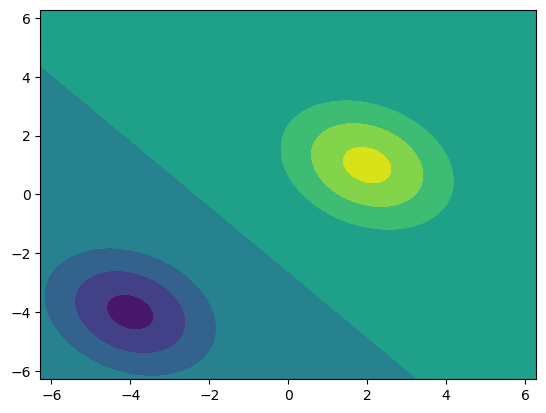

In [42]:
# initialization

# Mean vector and covariance matrix
mu = np.array([2., 1.])
sigma = np.array([[ 2. , -0.5], [-0.5,  2.]])

# Pack x and y into a single 3-dimensional array
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y

# Mean vector and covariance matrix
mu1 = np.array([-4., -4.])
sigma1 = np.array([[ 2. , -0.5], [-0.5,  2.]])

# Pack x and y into a single 3-dimensional array
pos1 = np.empty(x.shape + (2,))
pos1[:, :, 0] = x
pos1[:, :, 1] = y

psi = multivariate_gaussian(pos, mu, sigma) - multivariate_gaussian(pos1, mu1, sigma1)
print(psi)

plt.contourf(x,y,np.real(psi))

A = np.zeros((N,N), dtype=complex)
dAdx_fft = np.zeros((N,N), dtype=complex)
B = np.zeros((N,N), dtype=complex)
dBdy_fft = np.zeros((N,N), dtype=complex)

zeta_fft = np.zeros((N,N), dtype=complex)
u_fft = np.zeros((N,N), dtype=complex)
v_fft = np.zeros((N,N), dtype=complex)

K = np.arange(0,N)
L = np.arange(0,N)
dK = np.zeros(N, dtype=complex)
dL = np.zeros(N, dtype=complex)
d2KL = np.zeros((N,N), dtype=complex)

for k in K:
    dK[k] = 1j*k
    for l in L:
        dL[l] = 1j*l
        d2KL[k,l] = -k**2 - l**2

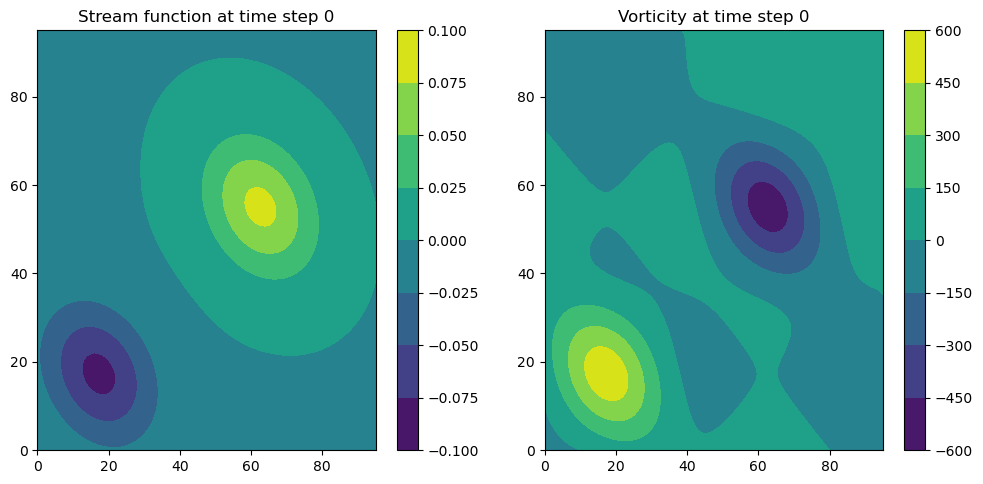

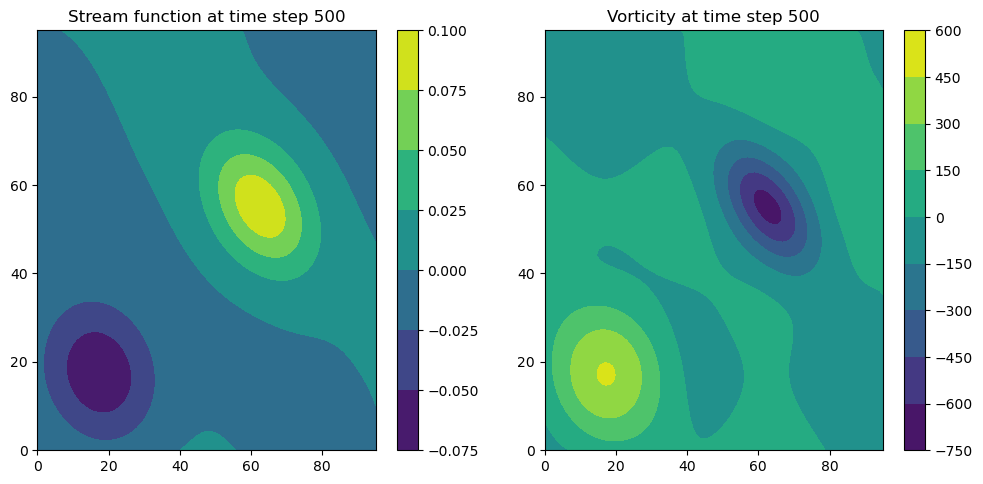

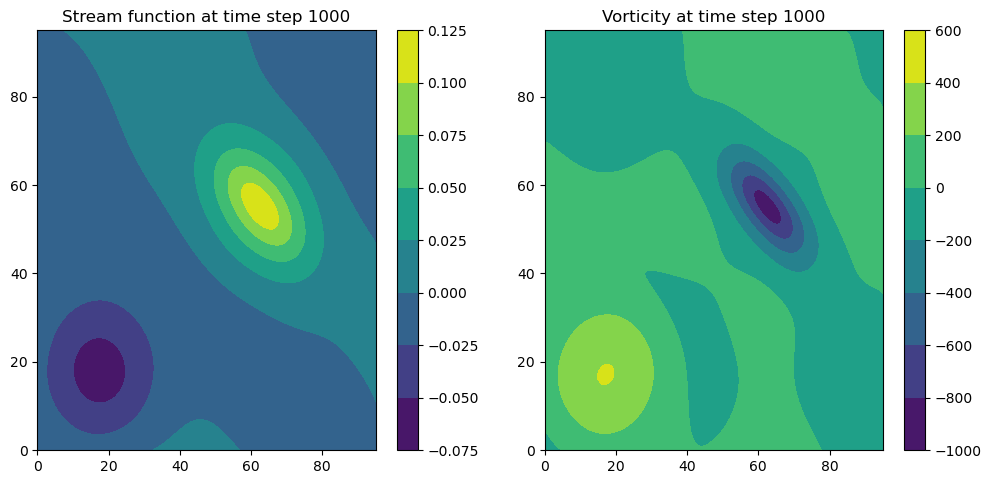

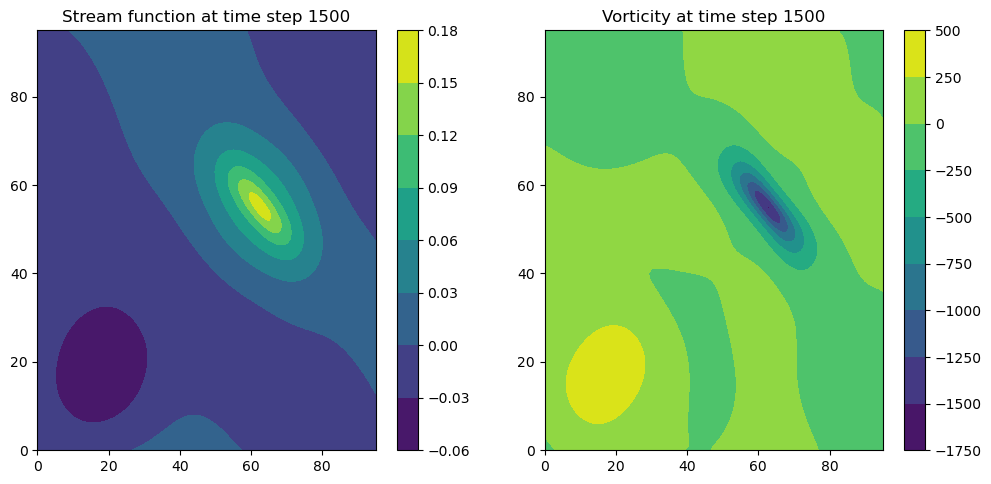

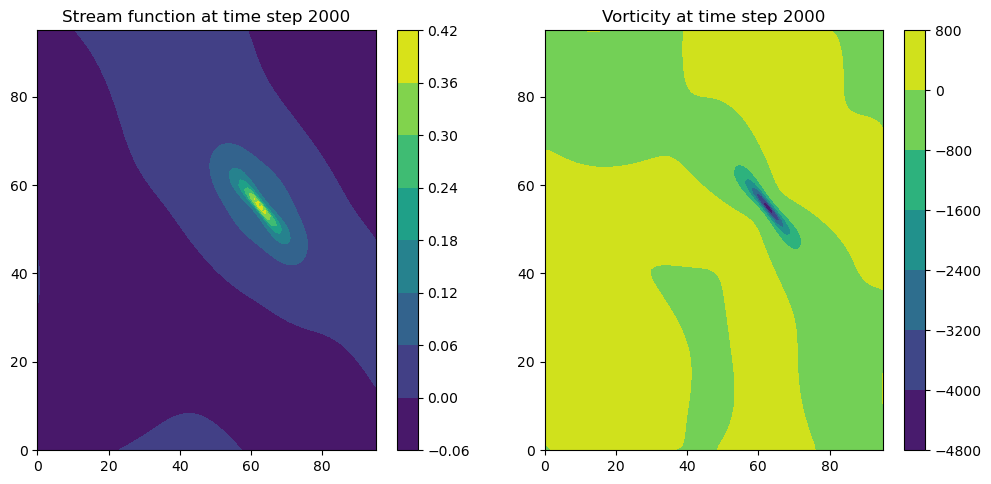

CPU times: user 2min 53s, sys: 197 ms, total: 2min 53s
Wall time: 2min 54s


In [43]:
%%time

# Use mesh for vectorization

for t in np.arange(0,T):
    #print(f'time step {t}')
    psi_fft = fft2(psi)
    
    for k in np.arange(0,N):
        for l in np.arange(0,N):
            zeta_fft[k,l] = (-k**2 - l**2)*psi_fft[k,l]
            u_fft[k,l] = -1j*l*psi_fft[k,l]
            v_fft[k,l] = 1j*k*psi_fft[k,l]
    
    zeta = ifft2(zeta_fft)
    u = ifft2(u_fft)
    v = ifft2(v_fft)
    # for i in np.arange(0,N):
    #     for j in np.arange(0,N):
    #         A[i,j] = -u[i,j]*zeta[i,j]
    #         B[i,j] = v[i,j]*zeta[i,j]
    A = -u*zeta
    B = v*zeta
    
    A_fft = fft2(A)
    B_fft = fft2(B)
    for k in np.arange(0,N):
        for l in np.arange(0,N):
            dAdx_fft[k,l] = 1j*k*A_fft[k,l]
            dBdy_fft[k,l] = 1j*l*B_fft[k,l]
    #dAdx_fft = 1j*k*A_fft
    #dBdy_fft = 1j*l*B_fft
    
    dAdx = ifft2(dAdx_fft)
    dBdy = ifft2(dBdy_fft)
    #print(dAdx)
    
    f = -dAdx - dBdy #- psi*beta
    #print(f)
    
    # integration
    if t == 0:
        # forward scheme
        even_zeta = zeta.copy()
        zeta += deltaT*f
        odd_zeta = zeta.copy()
    elif t % 2 == 1:
        # leap-frog odd steps
        even_zeta += 2*deltaT*f
        zeta = even_zeta.copy()
    else:
        # leap-frog even steps
        odd_zeta += 2*deltaT*f
        zeta = odd_zeta.copy()
    
    zeta_fft = fft2(zeta)
    
    for k in np.arange(0,N):
        for l in np.arange(0,N):
            if k == 0 and l == 0:
                psi_fft[k,l] = 0.0
            else:
                psi_fft[k,l] = zeta_fft[k,l]/(-k**2-l**2)
    psi = ifft2(psi_fft)
    
    if t%Tplot == 0:
        plot_model(psi, zeta, t)